In [6]:
import os
import gc
from settings import *
from utils import * 
import os, pickle
import tqdm 
from tqdm import trange
import time

from gensim.utils import tokenize 
from gensim.models import fasttext

import numpy as np

import torch 
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

In [7]:
with open(os.path.join(PICKLE_DIR, 'beauty.pickle'), 'rb') as f:
    beauty = pickle.load(f, encoding='utf-8')

beauty.loc[:,'label'] = beauty.overall.apply(lambda x: sentiment_score(x))
beauty = beauty.loc[:, ['reviewText', 'label']].copy()
beauty.dropna(inplace= True)
beauty.reset_index(inplace=True, drop=True)


In [258]:
with open(os.path.join(PICKLE_DIR, 'electronics.pickle'), 'rb') as f:
    electronics = pickle.load(f, encoding='utf-8')

electronics.loc[:,'label'] = electronics.overall.apply(lambda x: sentiment_score(x))
electronics = electronics.loc[:, ['reviewText', 'label']].copy()
electronics.dropna(inplace= True)
electronics.reset_index(inplace=True, drop=True)

In [72]:
fasttext_models = fasttext.load_facebook_model('pre_trained\\wiki.en.bin')

In [259]:
def data_loader(reviews, labels, batch_size, tokenizer=tokenize, embed_models=fasttext_models, max_len=512, latent_dim=300):
    total_len = len(reviews)
    for i in range(1, total_len, batch_size):
        if (i + batch_size) > total_len :
            total_sentences = np.empty([(total_len-i), max_len, latent_dim])

        else:
            total_sentences = np.empty([batch_size, max_len, latent_dim])

        review  = reviews[i:min(i+batch_size, total_len)]
        batch_label = [[np.int8(label)] for label in labels[i:min(i+batch_size, total_len)]]
        for batch, sent in enumerate(review):
            sentences = np.empty([max_len, latent_dim])
            tokenized_review = list(tokenizer(sent))

            if len(tokenized_review) < max_len:
                tokenized_review += (max_len - len(tokenized_review))*[""]
            
            else:
                tokenized_review = tokenized_review[:max_len]
            
            for j, token in enumerate(tokenized_review):
                sentences[j] = embed_models.wv[token]

            total_sentences[batch] = sentences.reshape(1, max_len, latent_dim)

        yield torch.Tensor(total_sentences), torch.Tensor(batch_label)

In [222]:
beauty_reviews = beauty.reviewText 
beauty_labels = beauty.label

In [260]:
electronics_reviews = electronics.reviewText 
electronics_labels = electronics.label

In [261]:
X_train, X_test, Y_train, Y_test = train_test_split(electronics_reviews, electronics_labels, test_size=0.3, random_state=42)

In [262]:
class LSTM(nn.Module):
    def __init__(self, embed_dim, hidden_dim, n_classes, n_layers, bidirectional=True, dr_rate=0.2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, batch_first=True)
        self.fc = nn.Linear(2*hidden_dim if bidirectional else hidden_dim, n_classes)
        self.dropout = nn.Dropout(dr_rate)
        self.sigmoid = nn.Sigmoid()

        self._init_weight()

    def forward(self, words):
        input = self.dropout(words)

        o, (h, c) = self.lstm(input)
        
        if self.lstm.bidirectional:
            h = torch.cat([h[-1], h[-2]], dim = -1)

        else:
            h = self.dropout(h[-1])

        output = self.fc(h)
        output = self.sigmoid(output)
        return output 

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
            
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'bias' in name:
                        nn.init.zeros_(param)
                    
                    elif 'weight' in name:
                        nn.init.orthogonal_(param)

In [263]:
vocab_size, embedding_dim = fasttext_models.wv.vectors.shape
hidden_dim = 128
n_classes = 1
bidirectional = True
n_layers = 2
dr_rate = 0.2
lr = 1e-3
num_epochs = 15

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [264]:
def calc_accuracy(pred_y, true_y):
    return ((pred_y > 0.5) == true_y).sum()

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time 
    elapsed_mins = elapsed_time // 60 
    elapsed_secs = elapsed_time - elapsed_mins*60
    return elapsed_mins, elapsed_secs 

In [265]:
lstm_models = LSTM(embedding_dim, hidden_dim, n_classes, n_layers, bidirectional, dr_rate).to(device)
criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(lstm_models.parameters(), lr = lr)

In [266]:
train_total = X_train.__len__()
test_total = X_test.__len__()
train_loss_list = []
train_acc_list = []

test_loss_list = []
test_acc_list = []


best_loss = float(np.inf)
with trange(num_epochs) as tr:

    for epoch in tr :
        start_time = time.time()
        train_loss = 0
        train_acc = 0

        lstm_models.train()
        for reviews, labels in data_loader(X_train, Y_train, batch_size=512):
            reviews = reviews.to(device)
            labels = labels.to(device)

            pred_y = lstm_models(reviews)
            loss = criterion(pred_y, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += calc_accuracy(pred_y, labels)
        train_acc = train_acc / train_total
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)

        test_loss = 0 
        test_acc = 0 

        lstm_models.eval()
        for reviews, labels in data_loader(X_test, Y_test, batch_size=512):
            reviews = reviews.to(device)
            labels = labels.to(device)

            pred_y = lstm_models(reviews)
            loss = criterion(pred_y, labels)

            test_loss += loss.item()
            test_acc += calc_accuracy(pred_y, labels)
        test_acc = test_acc / test_total
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)

        end_time = time.time()
        elapsed_mins, elapsed_secs = epoch_time(start_time, end_time)
        print(f'epoch [{epoch+1}/{num_epochs}] | elapsed time: {elapsed_mins}m {elapsed_secs:.2f}s')
        print(f'train loss: {train_loss:.4f}\ttrain accuracy: {train_acc*100:.2f}%')
        print(f'test loss: {test_loss:.4f}\ttest accuracy: {test_acc*100:.2f}%')

        if best_loss > test_loss :
            best_loss = test_loss
            best_epoch = epoch
            torch.save(lstm_models.state_dict(), 'beauty_best_parameter.pt')
            
    print(f'best_epochs:{best_epoch}')

  7%|▋         | 1/15 [2:59:40<41:55:23, 10780.28s/it]

epoch [1/15] | elapsed time: 179.0m 40.28s
train loss: 539.7492	train accuracy: 90.13%
test loss: 139.0879	test accuracy: 93.89%


 13%|█▎        | 2/15 [5:59:59<38:58:17, 10792.10s/it]

epoch [2/15] | elapsed time: 180.0m 19.68s
train loss: 291.9991	train accuracy: 94.63%
test loss: 104.9626	test accuracy: 95.52%


 20%|██        | 3/15 [9:00:44<36:01:34, 10807.84s/it]

epoch [3/15] | elapsed time: 180.0m 44.57s
train loss: 242.5608	train accuracy: 95.57%
test loss: 96.0795	test accuracy: 95.91%


 27%|██▋       | 4/15 [11:28:56<31:16:02, 10232.95s/it]

epoch [4/15] | elapsed time: 148.0m 11.55s
train loss: 218.0424	train accuracy: 96.02%
test loss: 87.0623	test accuracy: 96.32%


 33%|███▎      | 5/15 [13:54:57<27:11:54, 9791.50s/it] 

epoch [5/15] | elapsed time: 146.0m 1.41s
train loss: 201.6564	train accuracy: 96.32%
test loss: 82.6019	test accuracy: 96.52%


 40%|████      | 6/15 [16:23:36<23:49:28, 9529.85s/it]

epoch [6/15] | elapsed time: 148.0m 39.32s
train loss: 187.3414	train accuracy: 96.60%
test loss: 82.2526	test accuracy: 96.49%


 47%|████▋     | 7/15 [18:50:28<20:41:54, 9314.34s/it]

epoch [7/15] | elapsed time: 146.0m 51.48s
train loss: 174.6303	train accuracy: 96.84%
test loss: 80.3161	test accuracy: 96.63%


 53%|█████▎    | 8/15 [21:15:51<17:45:59, 9137.10s/it]

epoch [8/15] | elapsed time: 145.0m 23.53s
train loss: 163.2955	train accuracy: 97.05%
test loss: 80.8145	test accuracy: 96.57%


 60%|██████    | 9/15 [23:41:13<15:01:14, 9012.38s/it]

epoch [9/15] | elapsed time: 145.0m 21.38s
train loss: 153.2871	train accuracy: 97.23%
test loss: 81.5924	test accuracy: 96.59%


 60%|██████    | 9/15 [23:43:59<15:49:19, 9493.28s/it]


KeyboardInterrupt: 

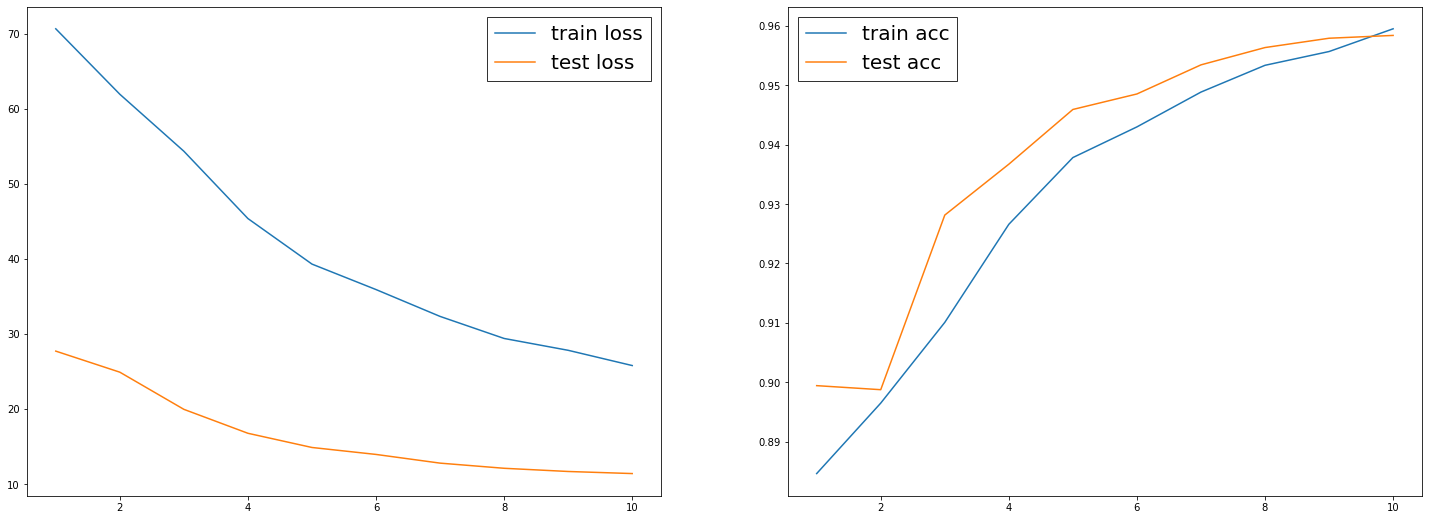

In [248]:
import matplotlib.pyplot as plt 
k = np.arange(1, num_epochs+1)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(25, 9))
axs[0].plot(k, train_loss_list[:10], label = 'train loss')
axs[0].plot(k, test_loss_list, label = 'test loss')
axs[0].legend(fontsize= 20, fancybox = False, edgecolor='black')

axs[1].plot(k, train_acc_list[:10], label = 'train acc')
axs[1].plot(k, test_acc_list, label = 'test acc')
axs[1].legend(fontsize= 20, fancybox = False, edgecolor='black')
plt.savefig('image/electronics_result.tif')
plt.show()